In [2]:
# imports
from __future__ import print_function
from __future__ import division
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
import cv2
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [3]:
# For every scan in the dataset, you will be predicting the 
# probability that a threat is present in each of 17 body zones.

# constants
COLORMAP = 'pink'
# APS_FILE_NAME = '/media/zj/study/kaggle/sample/00360f79fd6e02781457eda48f85da90.aps'
# APS_FILE_NAME = '/media/zj/study/kaggle/sample/0043db5e8c819bffc15261b1f1ac5e42.a3d'

# BODY_ZONES = '/media/zj/study/kaggle/body_zones.png'
THREAT_LABELS = 'S:\kaggle\stage1_labels.csv'

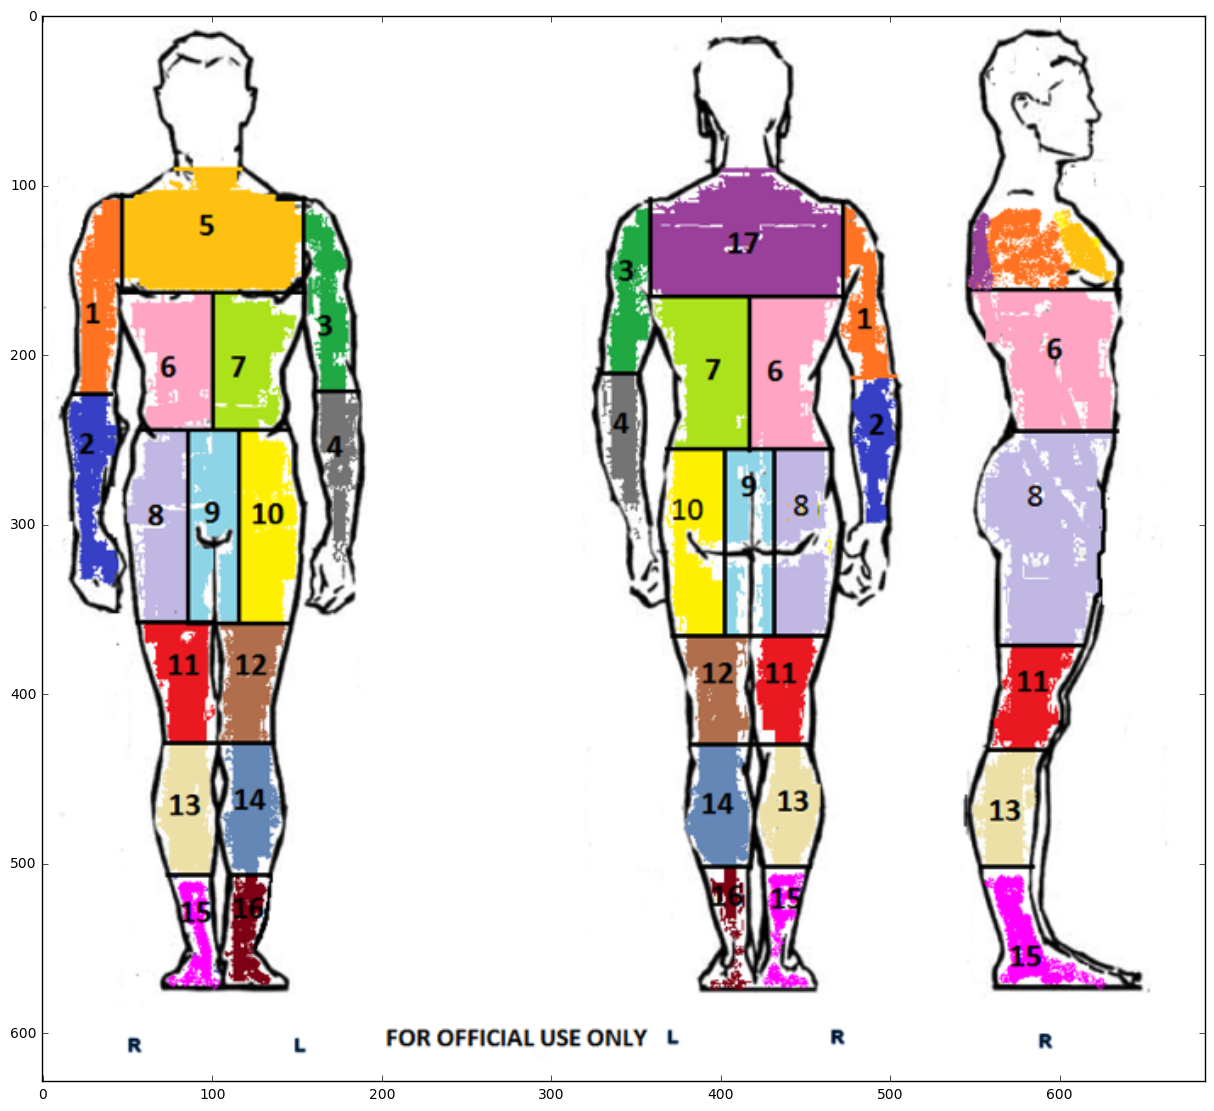

In [4]:
# show the threat zones
body_zones_img = plt.imread(BODY_ZONES)
fig, ax = plt.subplots(figsize=(15,15))  # figsize:1500*1500像素
ax.imshow(body_zones_img)

In [5]:
# Divide the available space on an image into 16 sectors. In the [0] image these
# zones correspond to the TSA threat zones.  But on rotated images, the slice
# list uses the sector that best shows the threat zone
# 把每张图片分割成16块，sector05表示区块5和17
sector01_pts = np.array([[0,160],[200,160],[200,230],[0,230]], np.int32)
sector02_pts = np.array([[0,0],[200,0],[200,160],[0,160]], np.int32)
sector03_pts = np.array([[330,160],[512,160],[512,240],[330,240]], np.int32)
sector04_pts = np.array([[350,0],[512,0],[512,160],[350,160]], np.int32)

# sector 5 is used for both threat zone 5 and 17
sector05_pts = np.array([[0,220],[512,220],[512,300],[0,300]], np.int32) 

sector06_pts = np.array([[0,300],[256,300],[256,360],[0,360]], np.int32)
sector07_pts = np.array([[256,300],[512,300],[512,360],[256,360]], np.int32)
sector08_pts = np.array([[0,370],[225,370],[225,450],[0,450]], np.int32)
sector09_pts = np.array([[225,370],[275,370],[275,450],[225,450]], np.int32)
sector10_pts = np.array([[275,370],[512,370],[512,450],[275,450]], np.int32)
sector11_pts = np.array([[0,450],[256,450],[256,525],[0,525]], np.int32)
sector12_pts = np.array([[256,450],[512,450],[512,525],[256,525]], np.int32)
sector13_pts = np.array([[0,525],[256,525],[256,600],[0,600]], np.int32)
sector14_pts = np.array([[256,525],[512,525],[512,600],[256,600]], np.int32)
sector15_pts = np.array([[0,600],[256,600],[256,660],[0,660]], np.int32)
sector16_pts = np.array([[256,600],[512,600],[512,660],[256,660]], np.int32)

# crop dimensions, upper left x, y, width, height
sector_crop_list = [[ 50,  50, 250, 250], # sector 1
                    [  0,   0, 250, 250], # sector 2
                    [ 50, 250, 250, 250], # sector 3
                    [250,   0, 250, 250], # sector 4
                    [150, 150, 250, 250], # sector 5/17
                    [200, 100, 250, 250], # sector 6
                    [200, 150, 250, 250], # sector 7
                    [250,  50, 250, 250], # sector 8
                    [250, 150, 250, 250], # sector 9
                    [300, 200, 250, 250], # sector 10
                    [400, 100, 250, 250], # sector 11
                    [350, 200, 250, 250], # sector 12
                    [410,   0, 250, 250], # sector 13
                    [410, 200, 250, 250], # sector 14
                    [410,   0, 250, 250], # sector 15
                    [410, 200, 250, 250], # sector 16
                   ]


In [6]:
# For each zone, we pick the sector with the best view of that threat 
# zone. Since there are 16 images per subject, each zone's slice list 
# contains 16 entries each naming the sector where the given threat 
# zone is best visible. At some angles, a given threat zone may not 
# be visible. We just set those values to None so that its easy to 
# iterate the list and ignore the scans where a given zone is not 
# visible.
# 对于每一个威胁区块，在16个不同角度的视图中，挑选可视化最好的区块．把某些可视化
# 很差的视图中的区块设置为None，方便遍历列表．

# In this notebook, I call this a threat zone slice list. To create a 
# feature for a given threat zone, I will iterate this list and use the
# vertices to establish a region of interest and mask off the threat 
# zone. Hopefully that's clear. If not it will be more clear below.

# I use the same technique to then crop the segmented images to reduce 
# the size.

# Alse it's worth noting, that I haven't yet extensively tested to make
# sure that there is no clipping. If someone finds a more optimal set 
# of vertices or notes meaningful clipping, please post it in the 
# discussion.
# 

# Each element in the zone_slice_list contains the sector to use in the call to roi()
zone_slice_list = [ [ # threat zone 1
                      sector01_pts, sector01_pts, sector01_pts, None, 
                      None, None, sector03_pts, sector03_pts, 
                      sector03_pts, sector03_pts, sector03_pts, 
                      None, None, sector01_pts, sector01_pts, sector01_pts ], 
    
                    [ # threat zone 2
                      sector02_pts, sector02_pts, sector02_pts, None, 
                      None, None, sector04_pts, sector04_pts, 
                      sector04_pts, sector04_pts, sector04_pts, None, 
                      None, sector02_pts, sector02_pts, sector02_pts ],
    
                    [ # threat zone 3
                      sector03_pts, sector03_pts, sector03_pts, sector03_pts, 
                      None, None, sector01_pts, sector01_pts,
                      sector01_pts, sector01_pts, sector01_pts, sector01_pts, 
                      None, None, sector03_pts, sector03_pts ],
    
                    [ # threat zone 4
                      sector04_pts, sector04_pts, sector04_pts, sector04_pts, 
                      None, None, sector02_pts, sector02_pts, 
                      sector02_pts, sector02_pts, sector02_pts, sector02_pts, 
                      None, None, sector04_pts, sector04_pts ],
    
                    [ # threat zone 5
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts, 
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts,
                      None, None, None, None, 
                      None, None, None, None ],
    
                    [ # threat zone 6
                      sector06_pts, None, None, None, 
                      None, None, None, None, 
                      sector07_pts, sector07_pts, sector06_pts, sector06_pts, 
                      sector06_pts, sector06_pts, sector06_pts, sector06_pts ],
    
                    [ # threat zone 7
                      sector07_pts, sector07_pts, sector07_pts, sector07_pts, 
                      sector07_pts, sector07_pts, sector07_pts, sector07_pts, 
                      None, None, None, None, 
                      None, None, None, None ],
    
                    [ # threat zone 8
                      sector08_pts, sector08_pts, None, None, 
                      None, None, None, sector10_pts, 
                      sector10_pts, sector10_pts, sector10_pts, sector10_pts, 
                      sector08_pts, sector08_pts, sector08_pts, sector08_pts ],
    
                    [ # threat zone 9
                      sector09_pts, sector09_pts, sector08_pts, sector08_pts, 
                      sector08_pts, None, None, None,
                      sector09_pts, sector09_pts, None, None, 
                      None, None, sector10_pts, sector09_pts ],
    
                    [ # threat zone 10
                      sector10_pts, sector10_pts, sector10_pts, sector10_pts, 
                      sector10_pts, sector08_pts, sector10_pts, None, 
                      None, None, None, None, 
                      None, None, None, sector10_pts ],
    
                    [ # threat zone 11
                      sector11_pts, sector11_pts, sector11_pts, sector11_pts, 
                      None, None, sector12_pts, sector12_pts,
                      sector12_pts, sector12_pts, sector12_pts, None, 
                      sector11_pts, sector11_pts, sector11_pts, sector11_pts ],
    
                    [ # threat zone 12
                      sector12_pts, sector12_pts, sector12_pts, sector12_pts, 
                      sector12_pts, sector11_pts, sector11_pts, sector11_pts, 
                      sector11_pts, sector11_pts, sector11_pts, None, 
                      None, sector12_pts, sector12_pts, sector12_pts ],
    
                    [ # threat zone 13
                      sector13_pts, sector13_pts, sector13_pts, sector13_pts, 
                      None, None, sector14_pts, sector14_pts,
                      sector14_pts, sector14_pts, sector14_pts, None, 
                      sector13_pts, sector13_pts, sector13_pts, sector13_pts ],
    
                    [ # sector 14
                      sector14_pts, sector14_pts, sector14_pts, sector14_pts, 
                      sector14_pts, None, sector13_pts, sector13_pts, 
                      sector13_pts, sector13_pts, sector13_pts, None, 
                      None, None, None, None ],
    
                    [ # threat zone 15
                      sector15_pts, sector15_pts, sector15_pts, sector15_pts, 
                      None, None, sector16_pts, sector16_pts,
                      sector16_pts, sector16_pts, None, sector15_pts, 
                      sector15_pts, None, sector15_pts, sector15_pts ],
    
                    [ # threat zone 16
                      sector16_pts, sector16_pts, sector16_pts, sector16_pts, 
                      sector16_pts, sector16_pts, sector15_pts, sector15_pts, 
                      sector15_pts, sector15_pts, sector15_pts, None, 
                      None, None, sector16_pts, sector16_pts ],
    
                    [ # threat zone 17
                      None, None, None, None, 
                      None, None, None, None,
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts, 
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts ] ]

# Each element in the zone_slice_list contains the sector to use in the call to roi()
zone_crop_list =  [ [ # threat zone 1
                      sector_crop_list[0], sector_crop_list[0], sector_crop_list[0], None, 
                      None, None, sector_crop_list[2], sector_crop_list[2], 
                      sector_crop_list[2], sector_crop_list[2], sector_crop_list[2], None, 
                      None, sector_crop_list[0], sector_crop_list[0], 
                      sector_crop_list[0] ],
    
                    [ # threat zone 2
                      sector_crop_list[1], sector_crop_list[1], sector_crop_list[1], None, 
                      None, None, sector_crop_list[3], sector_crop_list[3], 
                      sector_crop_list[3], sector_crop_list[3], sector_crop_list[3], 
                      None, None, sector_crop_list[1], sector_crop_list[1], 
                      sector_crop_list[1] ],
    
                    [ # threat zone 3
                      sector_crop_list[2], sector_crop_list[2], sector_crop_list[2], 
                      sector_crop_list[2], None, None, sector_crop_list[0], 
                      sector_crop_list[0], sector_crop_list[0], sector_crop_list[0], 
                      sector_crop_list[0], sector_crop_list[0], None, None, 
                      sector_crop_list[2], sector_crop_list[2] ],
               
                    [ # threat zone 4
                      sector_crop_list[3], sector_crop_list[3], sector_crop_list[3], 
                      sector_crop_list[3], None, None, sector_crop_list[1], 
                      sector_crop_list[1], sector_crop_list[1], sector_crop_list[1], 
                      sector_crop_list[1], sector_crop_list[1], None, None, 
                      sector_crop_list[3], sector_crop_list[3] ],
                    
                    [ # threat zone 5
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4],
                      None, None, None, None, None, None, None, None ],
                    
                    [ # threat zone 6
                      sector_crop_list[5], None, None, None, None, None, None, None, 
                      sector_crop_list[6], sector_crop_list[6], sector_crop_list[5], 
                      sector_crop_list[5], sector_crop_list[5], sector_crop_list[5], 
                      sector_crop_list[5], sector_crop_list[5] ],
    
                    [ # threat zone 7
                      sector_crop_list[6], sector_crop_list[6], sector_crop_list[6], 
                      sector_crop_list[6], sector_crop_list[6], sector_crop_list[6], 
                      sector_crop_list[6], sector_crop_list[6], 
                      None, None, None, None, None, None, None, None ],
    
                    [ # threat zone 8
                      sector_crop_list[7], sector_crop_list[7], None, None, None, 
                      None, None, sector_crop_list[9], sector_crop_list[9], 
                      sector_crop_list[9], sector_crop_list[9], sector_crop_list[9], 
                      sector_crop_list[7], sector_crop_list[7], sector_crop_list[7], 
                      sector_crop_list[7] ],
    
                    [ # threat zone 9
                      sector_crop_list[8], sector_crop_list[8], sector_crop_list[7], 
                      sector_crop_list[7], sector_crop_list[7], None, None, None,
                      sector_crop_list[8], sector_crop_list[8], None, None, None, 
                      None, sector_crop_list[9], sector_crop_list[8] ],
    
                    [ # threat zone 10
                      sector_crop_list[9], sector_crop_list[9], sector_crop_list[9], 
                      sector_crop_list[9], sector_crop_list[9], sector_crop_list[7], 
                      sector_crop_list[9], None, None, None, None, None, None, None, 
                      None, sector_crop_list[9] ],
    
                    [ # threat zone 11
                      sector_crop_list[10], sector_crop_list[10], sector_crop_list[10], 
                      sector_crop_list[10], None, None, sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], None, sector_crop_list[10], 
                      sector_crop_list[10], sector_crop_list[10], sector_crop_list[10] ],
    
                    [ # threat zone 12
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], None, None, 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11] ],
    
                    [ # threat zone 13
                      sector_crop_list[12], sector_crop_list[12], sector_crop_list[12], 
                      sector_crop_list[12], None, None, sector_crop_list[13], 
                      sector_crop_list[13], sector_crop_list[13], sector_crop_list[13], 
                      sector_crop_list[13], None, sector_crop_list[12], 
                      sector_crop_list[12], sector_crop_list[12], sector_crop_list[12] ],
    
                    [ # sector 14
                      sector_crop_list[13], sector_crop_list[13], sector_crop_list[13], 
                      sector_crop_list[13], sector_crop_list[13], None, 
                      sector_crop_list[13], sector_crop_list[13], sector_crop_list[12], 
                      sector_crop_list[12], sector_crop_list[12], None, None, None, 
                      None, None ],
    
                    [ # threat zone 15
                      sector_crop_list[14], sector_crop_list[14], sector_crop_list[14], 
                      sector_crop_list[14], None, None, sector_crop_list[15], 
                      sector_crop_list[15], sector_crop_list[15], sector_crop_list[15], 
                      None, sector_crop_list[14], sector_crop_list[14], None, 
                      sector_crop_list[14], sector_crop_list[14] ],
    
                    [ # threat zone 16
                      sector_crop_list[15], sector_crop_list[15], sector_crop_list[15], 
                      sector_crop_list[15], sector_crop_list[15], sector_crop_list[15], 
                      sector_crop_list[14], sector_crop_list[14], sector_crop_list[14], 
                      sector_crop_list[14], sector_crop_list[14], None, None, None, 
                      sector_crop_list[15], sector_crop_list[15] ],
    
                    [ # threat zone 17
                      None, None, None, None, None, None, None, None,
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4] ] ]

In [5]:
#----------------------------------------------------------------------------------
# read_header(infile):  takes an aps file and creates a dict of the data
#
# infile:               an aps file
#
# returns:              all of the fields in the header
#----------------------------------------------------------------------------------

def read_header(infile):
    # declare dictionary
    h = dict()
    
    with open(infile, 'r+b') as fid:

        h['filename'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 20))
        h['parent_filename'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 20))
        h['comments1'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 80))
        h['comments2'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 80))
        h['energy_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['config_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['file_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['trans_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scan_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['data_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['date_modified'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 16))
        h['frequency'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['mat_velocity'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['num_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_polarization_channels'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['spare00'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['adc_min_voltage'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['adc_max_voltage'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['band_width'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['spare01'] = np.fromfile(fid, dtype = np.int16, count = 5)
        h['polarization_type'] = np.fromfile(fid, dtype = np.int16, count = 4)
        h['record_header_size'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['word_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['word_precision'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['min_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['max_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['avg_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['data_scale_factor'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['data_units'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['surf_removal'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['edge_weighting'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['x_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['y_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['z_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['t_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['spare02'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['x_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['scan_orientation'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scan_direction'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['data_storage_order'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scanner_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['x_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['t_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['num_x_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_y_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_z_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_t_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['x_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['date_processed'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 8))
        h['time_processed'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 8))
        h['depth_recon'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['elevation_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['roll_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['azimuth_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['adc_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['spare06'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scanner_radius'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['t_delay'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['range_gate_start'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['range_gate_end'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['ahis_software_version'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['spare_end'] = np.fromfile(fid, dtype = np.float32, count = 10)

    return h
  
#unit test ----------------------------------
# header = read_header(APS_FILE_NAME)

# for data_item in sorted(header):
#    print ('{} -> {}'.format(data_item, header[data_item]))

In [7]:
#----------------------------------------------------------------------------------
# read_data(infile):  reads and rescales any of the four image types
#
# infile:             an .aps, .aps3d, .a3d, or ahi file
#
# returns:            the stack of images
#
# note:               word_type == 7 is an np.float32, word_type == 4 is np.uint16      
#----------------------------------------------------------------------------------

def read_data(infile):
    
    # read in header and get dimensions
    h = read_header(infile)
    nx = int(h['num_x_pts'])
    ny = int(h['num_y_pts'])
    nt = int(h['num_t_pts'])
    
    extension = os.path.splitext(infile)[1]
    
    with open(infile, 'rb') as fid:
          
        # skip the header
        fid.seek(512) 

        # handle .aps and .a3aps files
        if extension == '.aps' or extension == '.a3daps':
        
            if(h['word_type']==7):
                data = np.fromfile(fid, dtype = np.float32, count = nx * ny * nt)

            elif(h['word_type']==4): 
                data = np.fromfile(fid, dtype = np.uint16, count = nx * ny * nt)

            # scale and reshape the data
            data = data * h['data_scale_factor'] 
            data = data.reshape(nx, ny, nt, order='F').copy()

        # handle .a3d files
        elif extension == '.a3d':
              
            if(h['word_type']==7):
                data = np.fromfile(fid, dtype = np.float32, count = nx * ny * nt)
                
            elif(h['word_type']==4):
                data = np.fromfile(fid, dtype = np.uint16, count = nx * ny * nt)

            # scale and reshape the data
            data = data * h['data_scale_factor']
            data = data.reshape(nx, nt, ny, order='F').copy() 
            
        # handle .ahi files
        elif extension == '.ahi':
            data = np.fromfile(fid, dtype = np.float32, count = 2* nx * ny * nt)
            data = data.reshape(2, ny, nx, nt, order='F').copy()
            real = data[0,:,:,:].copy()
            imag = data[1,:,:,:].copy()

        if extension != '.ahi':
            return data
        else:
            return real, imag

#unit test ----------------------------------
# d = read_data(APS_FILE_NAME)

In [10]:
# The labels provided in the contest treat the subject number and 
# threat zone as a combined label. But to calculate the descriptive 
# stats I want to seperate them so that we can get total counts for
# each threat zone. Also, in this preprocessing approach, we will make
# individual examples out of each threat zone treating each zone as a 
# separate model. the next three functions work with this data.

# 把人物ID和区块ID区分开来，统计每个区块出现威胁的次数．
# 每个区块做一个独立的模型．


#----------------------------------------------------------------------------------------
# get_hit_rate_stats(infile):  gets the threat probabilities in a useful form
#
# infile:                      labels csv file
#
# returns:                     a dataframe of the summary hit probabilities
#
#----------------------------------------------------------------------------------------

# sum: 每个区块出现威胁的次数
# count:　每个区块的总个数，即subject的个数
# pct: 每个区块出现威胁的概率．
def get_hit_rate_stats(infile):
    # pull the labels for a given subject
    df = pd.read_csv(infile)

    # Separate the zone and subject id into a df
    # split("_", num_of_split):该方法第一个参数为分割字符，第二个参数为分割次数
    df['Subject'], df['Zone'] = df['Id'].str.split('_',1).str
    df = df[['Subject', 'Zone', 'Probability']]

    # make a df of the sums and counts by zone and calculate hit rate per zone, then sort high to low
    df_summary = df.groupby('Zone')['Probability'].agg(['sum','count'])
    df_summary['Zone'] = df_summary.index
    df_summary['pct'] = df_summary['sum'] / df_summary['count']
    df_summary.sort_values('pct', axis=0, ascending= False, inplace=True)
    
    return df_summary

# unit test -----------------------
df = get_hit_rate_stats(THREAT_LABELS)
df.head(30)



,sum,count,Zone,pct
Zone,,,,
Zone1,133,1147,Zone1,0.115955
Zone2,126,1147,Zone2,0.109852
Zone8,124,1147,Zone8,0.108108
Zone14,122,1147,Zone14,0.106364
Zone15,118,1147,Zone15,0.102877
Zone11,116,1147,Zone11,0.101133
Zone6,116,1147,Zone6,0.101133
Zone13,110,1147,Zone13,0.095902
Zone16,109,1147,Zone16,0.095031


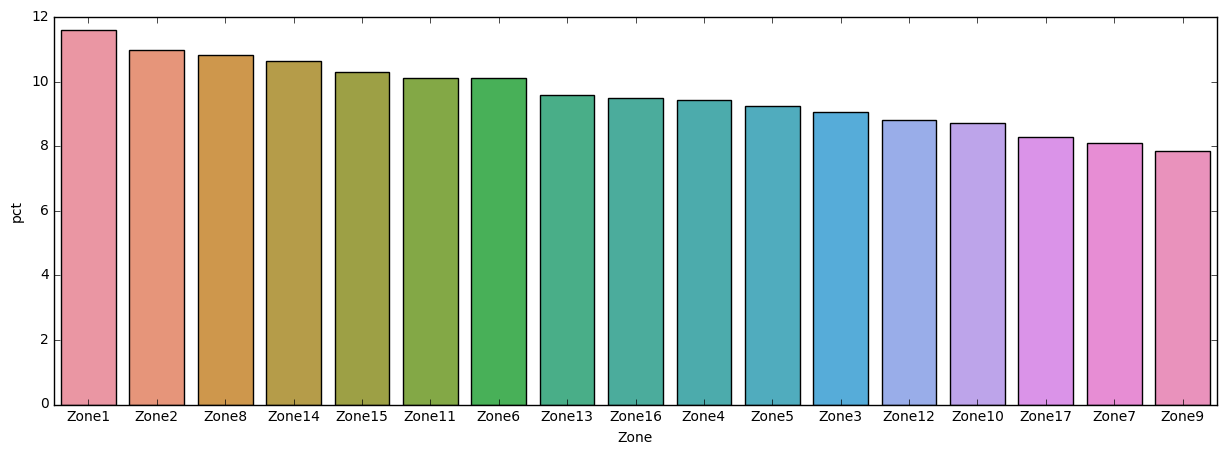

In [11]:
#------------------------------------------------------------------------------------------
# chart_hit_rate_stats(df_summary): charts threat probabilities in desc order by zone
#
# df_summary:                 a dataframe like that returned from get_hit_rate_stats(...)
#
#-------------------------------------------------------------------------------------------
import seaborn as sns
def chart_hit_rate_stats(df_summary):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.barplot(ax=ax, x=df_summary['Zone'], y=df_summary['pct']*100)

# unit test ------------------
chart_hit_rate_stats(df)

In [12]:
#------------------------------------------------------------------------------------------
# print_hit_rate_stats(df_summary): lists threat probabilities by zone
#
# df_summary:               a dataframe like that returned from get_hit_rate_stats(...)
#
#------------------------------------------------------------------------------------------

def print_hit_rate_stats(df_summary):
    # print the table of values readbly
    print ('{:6s}   {:>4s}   {:6s}'.format('Zone', 'Hits', 'Pct %'))
    print ('------   ----- ----------')
    for zone in df_summary.iterrows():
        print ('{:6s}   {:>4d}   {:>6.3f}%'.format(zone[0], np.int16(zone[1]['sum']), zone[1]['pct']*100))
    print ('------   ----- ----------')
    print ('{:6s}   {:>4d}   {:6.3f}%'.format('Total ', np.int16(df_summary['sum'].sum(axis=0)), 
                                             ( df_summary['sum'].sum(axis=0) / df_summary['count'].sum(axis=0))*100))

# unit test -----------------------
print_hit_rate_stats(df)

Zone     Hits   Pct % 
------   ----- ----------
Zone1     133   11.595%
Zone2     126   10.985%
Zone8     124   10.811%
Zone14    122   10.636%
Zone15    118   10.288%
Zone11    116   10.113%
Zone6     116   10.113%
Zone13    110    9.590%
Zone16    109    9.503%
Zone4     108    9.416%
Zone5     106    9.241%
Zone3     104    9.067%
Zone12    101    8.806%
Zone10    100    8.718%
Zone17     95    8.282%
Zone7      93    8.108%
Zone9      90    7.847%
------   ----- ----------
Total    1871    9.595%


In [13]:
#----------------------------------------------------------------------------------------
# def get_subject_labels(infile, subject_id): lists threat probabilities by zone
#
# infile:                          labels csv file
#
# subject_id:                      the individual you want the threat zone labels for
#
# returns:                         a df with the list of zones and contraband (0 or 1)
#
#---------------------------------------------------------------------------------------

# 根据标签文件和指定的subject id，得到subject id 的标签值
def get_subject_labels(infile, subject_id):

    # read labels into a dataframe
    df = pd.read_csv(infile)

    # Separate the zone and subject id into a df
    df['Subject'], df['Zone'] = df['Id'].str.split('_',1).str
    df = df[['Subject', 'Zone', 'Probability']]
    threat_list = df.loc[df['Subject'] == subject_id]
    
    return threat_list
    

    
# unit test ----------------------------------------------------------------------
print(get_subject_labels(THREAT_LABELS, '00360f79fd6e02781457eda48f85da90'))

                             Subject    Zone  Probability
0   00360f79fd6e02781457eda48f85da90   Zone1            0
1   00360f79fd6e02781457eda48f85da90  Zone10            0
2   00360f79fd6e02781457eda48f85da90  Zone11            0
3   00360f79fd6e02781457eda48f85da90  Zone12            0
4   00360f79fd6e02781457eda48f85da90  Zone13            0
5   00360f79fd6e02781457eda48f85da90  Zone14            1
6   00360f79fd6e02781457eda48f85da90  Zone15            0
7   00360f79fd6e02781457eda48f85da90  Zone16            0
8   00360f79fd6e02781457eda48f85da90  Zone17            0
9   00360f79fd6e02781457eda48f85da90   Zone2            0
10  00360f79fd6e02781457eda48f85da90   Zone3            0
11  00360f79fd6e02781457eda48f85da90   Zone4            0
12  00360f79fd6e02781457eda48f85da90   Zone5            0
13  00360f79fd6e02781457eda48f85da90   Zone6            0
14  00360f79fd6e02781457eda48f85da90   Zone7            0
15  00360f79fd6e02781457eda48f85da90   Zone8            0
16  00360f79fd

Done!


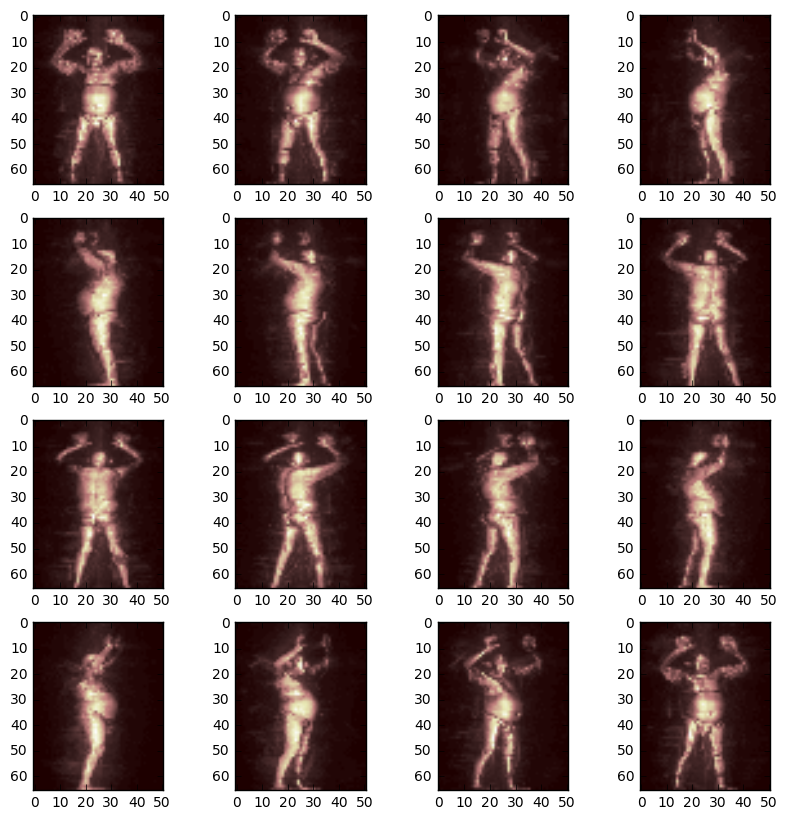

In [8]:
#----------------------------------------------------------------------------------
# plot_image_set(infile):  takes an aps file and shows all 16 90 degree shots
#
# infile:                  an aps file
#----------------------------------------------------------------------------------
# 显示.aps文件的所有16个视图
def plot_image_set(infile):

    # read in the aps file, it comes in as shape(512, 620, 16)
    img = read_data(infile)
    
    # transpose so that the slice is the first dimension shape(16, 620, 512)
    img = img.transpose()
        
    # show the graphs
    fig, axarr = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
    
    i = 0
    for row in range(4):
        for col in range(4):
            resized_img = cv2.resize(img[i], (0,0), fx=0.1, fy=0.1)
            axarr[row, col].imshow(np.flipud(resized_img), cmap=COLORMAP)
            i += 1
    
    print('Done!')

# unit test ----------------------------------
APS_FILE = r"S:\kaggle\stage1_aps\08dc52d08482393070d8c71b11902636.aps"
plot_image_set(APS_FILE)

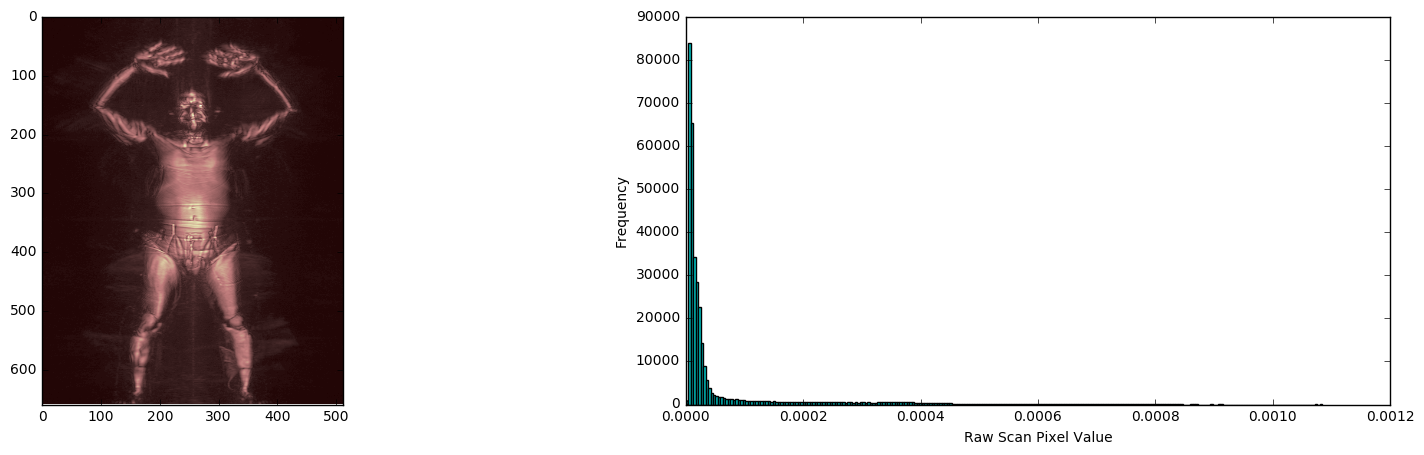

In [41]:
#----------------------------------------------------------------------------------
# get_single_image(infile, nth_image):  returns the nth image from the image stack
#
# infile:                              an aps file
#
# returns:                             an image
#----------------------------------------------------------------------------------

# 获取单一.aps文件的第n张视图
def get_single_image(infile, nth_image):

    # read in the aps file, it comes in as shape(512, 620, 16)
    img = read_data(infile)
    
    # transpose so that the slice is the first dimension shape(16, 620, 512)
    img = img.transpose()
    
    return np.flipud(img[nth_image])

  

# unit test ---------------------------------------------------------------
an_img = get_single_image(APS_FILE_NAME, 0)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axarr[0].imshow(an_img, cmap=COLORMAP)
plt.subplot(122)
plt.hist(an_img.flatten(), bins=256, color='c')
plt.xlabel("Raw Scan Pixel Value")
plt.ylabel("Frequency")
plt.show()

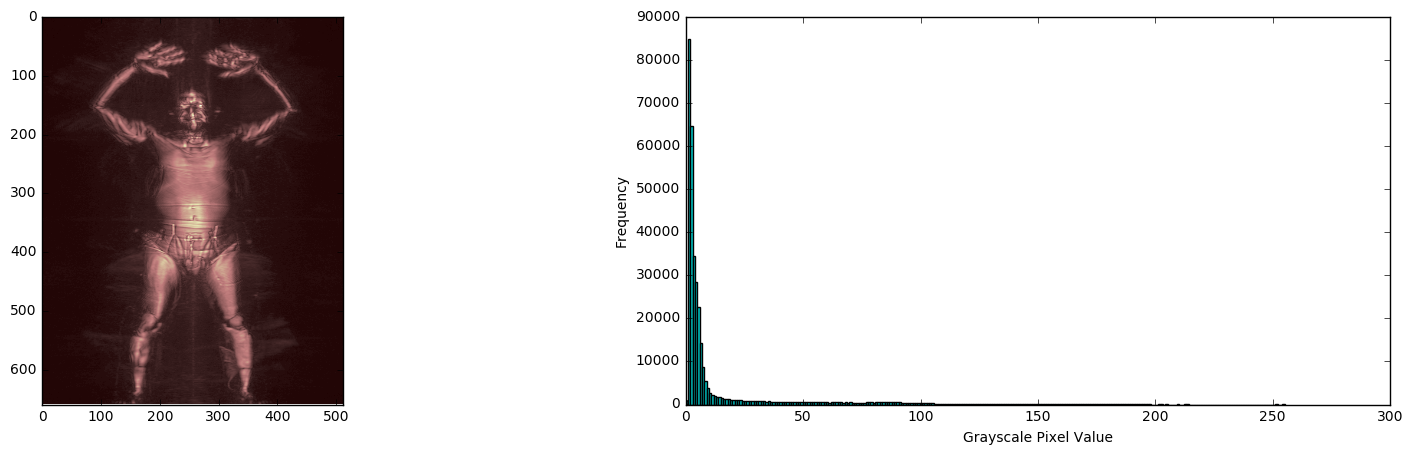

In [44]:
 #----------------------------------------------------------------------------------
# convert_to_grayscale(img):           converts a ATI scan to grayscale
#
# infile:                              an aps file
#
# returns:                             an image
#----------------------------------------------------------------------------------
# 把图片转化为灰度图片　Rescaling the Image
def convert_to_grayscale(img):
    # scale pixel values to grayscale
    base_range = np.amax(img) - np.amin(img)
    rescaled_range = 255 - 0
    img_rescaled = (((img - np.amin(img)) * rescaled_range) / base_range)

    return np.uint8(img_rescaled)

# unit test ------------------------------------------
img_rescaled = convert_to_grayscale(an_img)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axarr[0].imshow(img_rescaled, cmap=COLORMAP)
plt.subplot(122)
plt.hist(img_rescaled.flatten(), bins=256, color='c')
plt.xlabel("Grayscale Pixel Value")
plt.ylabel("Frequency")
plt.show()

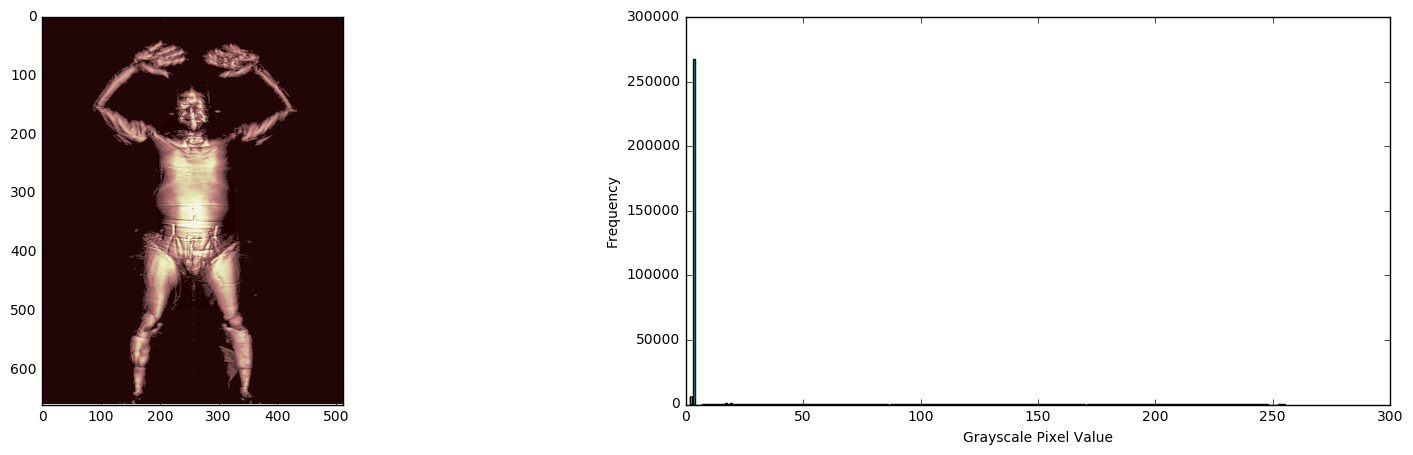

In [45]:
#-------------------------------------------------------------------------------
# spread_spectrum(img):        applies a histogram equalization transformation
#
# img:                         a single scan
#
# returns:                     a transformed scan
#-------------------------------------------------------------------------------

# 传播光谱
def spread_spectrum(img):
    img = stats.threshold(img, threshmin=12, newval=0)
    
    # see http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img= clahe.apply(img)
    
    return img
  
# unit test ------------------------------------------
img_high_contrast = spread_spectrum(img_rescaled)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axarr[0].imshow(img_high_contrast, cmap=COLORMAP)
plt.subplot(122)
plt.hist(img_high_contrast.flatten(), bins=256, color='c')
plt.xlabel("Grayscale Pixel Value")
plt.ylabel("Frequency")
plt.show()

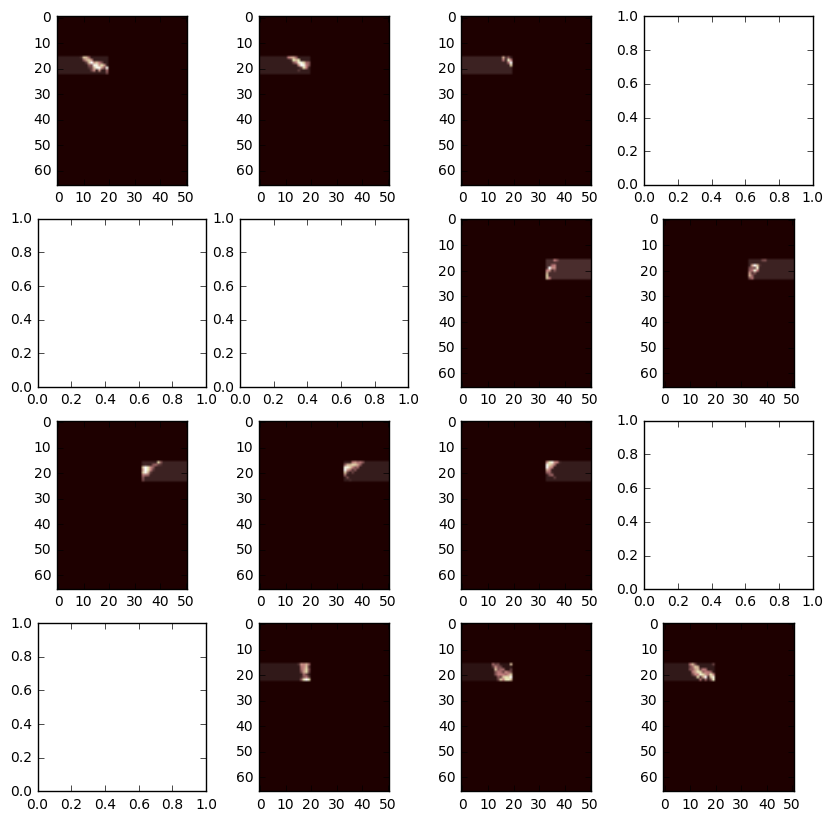

In [46]:
#-----------------------------------------------------------------------------------------
# roi(img, vertices):              uses vertices to mask the image
#
# img:                             the image to be masked
#
# vertices:                        a set of vertices that define the region of interest
#
# returns:                         a masked image
#-----------------------------------------------------------------------------------------
def roi(img, vertices):
    
    # blank mask
    mask = np.zeros_like(img)

    # fill the mask
    cv2.fillPoly(mask, [vertices], 255)

    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    

    return masked
  
# unit test -----------------------------------------------------------------
fig, axarr = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
   
i = 0
for row in range(4):
   for col in range(4):
       an_img = get_single_image(APS_FILE_NAME, i)
       img_rescaled = convert_to_grayscale(an_img)
       img_high_contrast = spread_spectrum(img_rescaled)
       if zone_slice_list[0][i] is not None:
           masked_img = roi(img_high_contrast, zone_slice_list[0][i])
           resized_img = cv2.resize(masked_img, (0,0), fx=0.1, fy=0.1)
           axarr[row, col].imshow(resized_img, cmap=COLORMAP)
       i += 1

/home/zj/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0


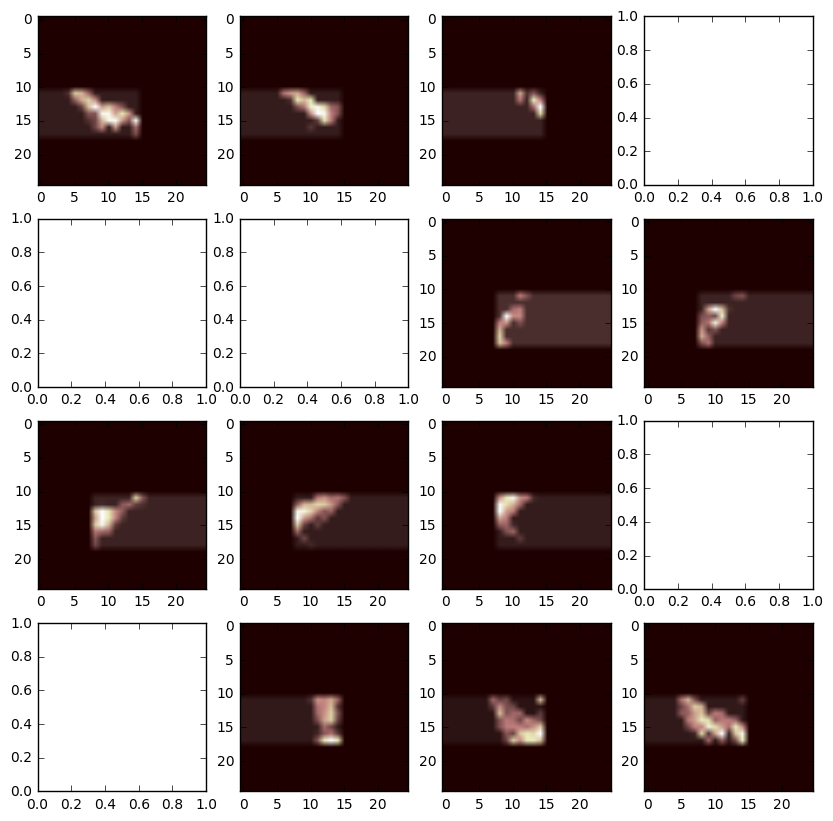

In [71]:
#-----------------------------------------------------------------------------------------
# crop(img, crop_list):                uses vertices to mask the image
#
# img:                                 the image to be cropped
#
# crop_list:                           a crop_list entry with [x , y, width, height]
#
# returns:                             a cropped image
#-----------------------------------------------------------------------------------------
def crop(img, crop_list):

    x_coord = crop_list[0]
    y_coord = crop_list[1]
    width = crop_list[2]
    height = crop_list[3]
    cropped_img = img[x_coord:x_coord+width, y_coord:y_coord+height]
    
    return cropped_img
  
# unit test -----------------------------------------------------------------

fig, axarr = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
   
i = 0
for row in range(4):
   for col in range(4):
       an_img = get_single_image(APS_FILE_NAME, i)
       img_rescaled = convert_to_grayscale(an_img)
       img_high_contrast = spread_spectrum(img_rescaled)
       if zone_slice_list[0][i] is not None:
           masked_img = roi(img_high_contrast, zone_slice_list[0][i])
           cropped_img = crop(masked_img, zone_crop_list[0][i])
           resized_img = cv2.resize(cropped_img, (0,0), fx=0.1, fy=0.1)
           axarr[row, col].imshow(resized_img, cmap=COLORMAP)
       i += 1

In [73]:
#------------------------------------------------------------------------------------------
# normalize(image): Take segmented tsa image and normalize pixel values to be 
#                   between 0 and 1
#
# parameters:      image - a tsa scan
#
# returns:         a normalized image
#
#------------------------------------------------------------------------------------------

def normalize(image):
    MIN_BOUND = 0.0
    MAX_BOUND = 255.0
    
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

#unit test ---------------------
an_img = get_single_image(APS_FILE_NAME, 0)
img_rescaled = convert_to_grayscale(an_img)
img_high_contrast = spread_spectrum(img_rescaled)
masked_img = roi(img_high_contrast, zone_slice_list[0][0])
cropped_img = crop(masked_img, zone_crop_list[0][0])
normalized_img = normalize(cropped_img)
print ('Normalized: length:width -> {:d}:{:d}|mean={:f}'.format(len(normalized_img), len(normalized_img[0]), normalized_img.mean()))
print (' -> type ', type(normalized_img))
print (' -> shape', normalized_img.shape)

Normalized: length:width -> 250:250|mean=0.014327
 -> type  <class 'numpy.ndarray'>
 -> shape (250, 250)


/home/zj/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0


In [74]:
#-------------------------------------------------------------------------------------
# zero_center(image): Shift normalized image data and move the range so it is 0 c
#                     entered at the PIXEL_MEAN
#
# parameters:         image
#
# returns:            a zero centered image
#
#-----------------------------------------------------------------------------------------------------------
def zero_center(image):
     
    PIXEL_MEAN = 0.014327
    
    image = image - PIXEL_MEAN
    return image

#unit test ---------------------
an_img = get_single_image(APS_FILE_NAME, 0)
img_rescaled = convert_to_grayscale(an_img)
img_high_contrast = spread_spectrum(img_rescaled)
masked_img = roi(img_high_contrast, zone_slice_list[0][0])
cropped_img = crop(masked_img, zone_crop_list[0][0])
normalized_img = normalize(cropped_img)
zero_centered_img = zero_center(normalized_img)
print ('Zero Centered: length:width -> {:d}:{:d}|mean={:f}'.format(len(zero_centered_img), len(zero_centered_img[0]), zero_centered_img.mean()))
print ('Conformed: Type ->', type(zero_centered_img), 'Shape ->', zero_centered_img.shape)

Zero Centered: length:width -> 250:250|mean=0.000000
Conformed: Type -> <class 'numpy.ndarray'> Shape -> (250, 250)


/home/zj/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0
